<a href="https://colab.research.google.com/github/DannyCollinson/EMIT-ECOSTRESS/blob/Autoencoder/EEAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory notebook

In [2]:
!pip install netCDF4
!pip install imagecodecs

In [3]:
import os

from tifffile import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from netCDF4 import Dataset as ncDataset
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [4]:
# Initialize RNG
rng = np.random.default_rng()

# Check if running with GPU runtime
torch.cuda.is_available()

True

## Pull latest from git repos

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/EMIT-ECOSTRESS')
!git pull https://github.com/DannyCollinson/EMIT-ECOSTRESS.git

From https://github.com/DannyCollinson/EMIT-ECOSTRESS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [7]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/VITALS')
!git pull https://github.com/DannyCollinson/VITALS.git

From https://github.com/DannyCollinson/VITALS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


## Load and explore ECOSTRESS average LST data LA day/night summer 2018-2021

In [8]:
im_day = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_daytime_summer_LST_2018_2021.tif')
im_night = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_nighttime_summer_LST_2018_2021.tif')

In [9]:
day_vals = im_day[~np.isnan(im_day)]
night_vals = im_night[~np.isnan(im_night)]

## Load and explore EMIT data 2023-07-28

In [10]:
# emit_002 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214106_2320914_002.nc')
emit_003 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214118_2320914_003.nc')
for key in vars(emit_003).keys():
    continue
    print(key)
    # print(vars(emit_002)[key])
    print(vars(emit_003)[key], end='\n\n')

In [11]:
# emit_002_data = emit_002.variables['reflectance'][:,:,:]
emit_003_data = emit_003.variables['reflectance'][:,:,:]
np.sum(emit_003_data.mask)# , np.sum(emit_002_data.mask)

0

#### Clean EMIT data and revisualize
We want to clip values to the range [0,1] and remove the channels that are always 0.

In [12]:
emit_003_data = np.clip(emit_003_data, 0, 1)
emit_003_data = emit_003_data[:, :, np.sum(emit_003_data, axis=(0,1)) > 0]

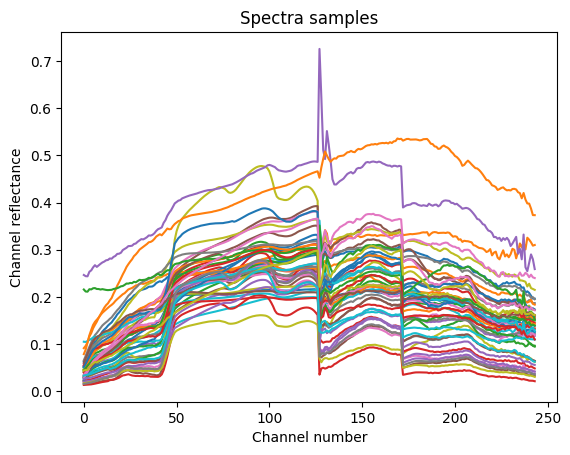

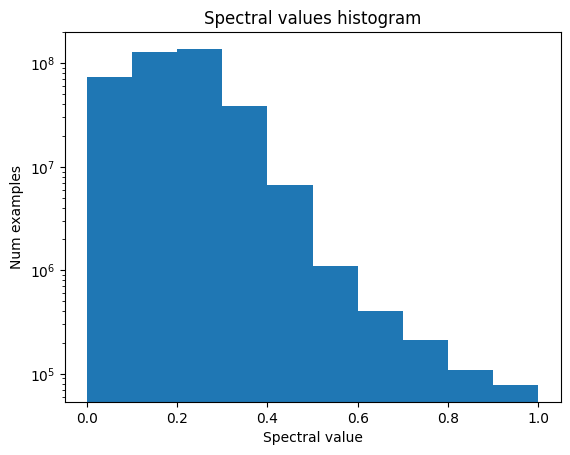

In [ ]:
fig, ax = plt.subplots()
ax.title.set_text('Spectra samples')
ax.set_xlabel('Channel number')
ax.set_ylabel('Channel reflectance')
num_spectra = 50
for i, j in zip(
    rng.choice(np.arange(emit_003_data.shape[0]), size=num_spectra),
    rng.choice(np.arange(emit_003_data.shape[1]), size=num_spectra),
):
    ax.plot(
        np.arange(len(emit_003_data[i,j,:].data)),
        emit_003_data[i,j,:].data,
    )
plt.show(fig)

fig, ax = plt.subplots()
ax.title.set_text('Spectral values histogram')
ax.set_xlabel('Spectral value')
ax.set_ylabel('Num examples')
ax.hist(emit_003_data[:, :, :].flatten(), log=True)
plt.show(fig)

## PCA on spectra

#### Standard PCA

In [ ]:
pca = PCA(n_components=0.9999)
pca_spectra = pca.fit_transform(
    emit_003_data.reshape(
        emit_003_data.shape[0] * emit_003_data.shape[1],
        emit_003_data.shape[2],
    )
)
pca_spectra = pca_spectra.reshape(
    emit_003_data.shape[0],
    emit_003_data.shape[1],
    pca_spectra.shape[1],
)

KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('n components')
ax.set_ylabel('Cumulative explained variance ratio')
ax.plot(np.arange(len(pca.explained_variance_ratio_)), [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_) + 1)])
plt.show(fig)
[np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_) + 1)][:10]

Autoencoder on 003 Spectra

In [21]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # basic autoencoder
        #
        # super(Autoencoder, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Linear(input_dim, encoding_dim),
        #     nn.ReLU()
        # )
        # self.decoder = nn.Sequential(
        #     nn.Linear(encoding_dim, input_dim),
        #     nn.Sigmoid()
        # )
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = 244
encoding_dim = 31
model = Autoencoder(input_dim, encoding_dim)

device = torch.device("cuda:0")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

emit_003_data = (emit_003_data).cpu()

emit_003_data = np.ma.getdata(emit_003_data)

emit_003_data = torch.tensor(emit_003_data, device=device)

data_loader = DataLoader(emit_003_data, batch_size=16, shuffle=True)

num_epochs = 10

losses = []

epoch_losses = []

for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()

        batch = batch.to(device)

        output = model(batch)
        loss = criterion(output, batch)

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(average_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

torch.save(model.state_dict(), 'autoencoder.pth')

model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)

with torch.no_grad():
    emit_003_data = emit_003_data.to(device)
    reconstructed_data = model(emit_003_data)

with torch.no_grad():
    latent_representation = model.encoder(emit_003_data)


Epoch [1/10], Loss: 0.008033700287342072
Epoch [2/10], Loss: 0.001030153944157064
Epoch [3/10], Loss: 0.0004397005250211805
Epoch [4/10], Loss: 0.0003110281832050532
Epoch [5/10], Loss: 0.00024703622329980135
Epoch [6/10], Loss: 0.00018385492148809135
Epoch [7/10], Loss: 9.416129614692181e-05
Epoch [8/10], Loss: 9.482374298386276e-05
Epoch [9/10], Loss: 0.00021236603788565844
Epoch [10/10], Loss: 7.568659202661365e-05


In [ ]:
print(reconstructed_data)

print(latent_representation)

latent_representation.shape


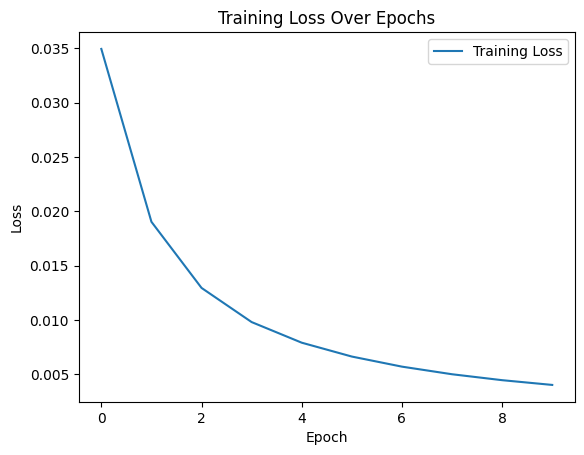

In [22]:
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# functional but does not use cuda

# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, encoding_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, input_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# input_dim = 244
# encoding_dim = 31
# model = Autoencoder(input_dim, encoding_dim)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# data_loader = DataLoader(emit_003_data, batch_size=16, shuffle=True)

# # emit_003_data_transposed = emit_003_data.T

# num_epochs = 10

# for epoch in range(num_epochs):
#     for batch in data_loader:
#         optimizer.zero_grad()

#         output = model(batch)
#         loss = criterion(output, batch)

#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


In [ ]:
model.eval()